In [1]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
import glob as glob
import re
import string
import numpy as np
import pandas as pd
import json

In [3]:
import spacy

In [4]:
spacy.__version__

'3.0.3'

In [5]:
nlp = spacy.load("it_core_news_sm")

frase_esempio = "Mi piace New York"

doc = nlp(frase_esempio)

for n, token in enumerate(doc):
    print(f"{n+1}) {token}")

1) Mi
2) piace
3) New
4) York


In [6]:
nlp.add_pipe("merge_entities")

doc = nlp(frase_esempio)

for n, token in enumerate(doc):
    print(f"{n+1}) {token}")

1) Mi
2) piace
3) New York


## Generator articoli

Quando il dataset si compone di moltissimi articoli diventa dispendioso, in termini di tempo, costruire prima una lista con i nomi dei files e poi ciclare nuovamente quest'ultima per elaborarne il contenuto.

A questo scopo è utile utilizzare la libreria "glob" la quale permette anche di "filtrare" gli articoli in base al nome ed all'estensione.

In [7]:
articoli = iter(glob.glob("archivio/*.txt"))

In [8]:
next(articoli)

'archivio/articolo_tecnologia_69.txt'

##### La classe di appartenenza dell'articolo è inserita nel nome del file tra due "_", la estrarremo attraverso una espressione regolare

Strumenti come Spacy e le regular expression possono essere molto utili per costruire un dataset strutturato partendo da dati semi-strutturati o, peggio, non strutturati.

In [9]:
keywords = re.compile(r"_(\w+)_")

#### Anteprima file

Prima di costruire la funzione per estrarre il contenuto del file guardiamo un'anteprima

In [10]:
articolo = next(articoli)

with open(articolo, 'r') as f:
    testo = f.readlines()
    testo = "".join(testo)

print(testo[:100])
print("-"*100)
print(testo[-100:])

<article><title>Potenza Calcio</title><body>Il Potenza Calcio S.r.l., meglio noto come Potenza, è un
----------------------------------------------------------------------------------------------------
'Internet Archive", 'Categoria:Voci con modulo citazione e parametro pagine']</categories></article>


Il contenuto del file è organizzato in tag annidati, attraverso le regular expressions possiamo estrarre queste informazioni in modo strutturato.

In particolare possiamo notare che il tag "categories" necessita di particolare "pulizia".

##### Altra regular expression per estrarre i dati in formato dictionary

In [11]:
tags = re.compile(r"<title>(?P<titolo>.*)</title><body>(?P<corpo>.*)</body><categories>(?P<categorie>.*)</categories>")

##### Estrazione e Primo preprocessing

In [12]:
def estrati_dati(articolo):
    
    # Identificazione della class/keywords estraendola dal nome del file
    kw = keywords.findall(articolo)[0]

    with open(articolo, 'r') as f:
        testo = f.readlines()
        
    testo = "".join(testo)
    testo = testo.replace("\n","")
    
    # Estrazione dei campi di interesse per ottenere il dictionary
    m = tags.search(testo)
    dati = m.groupdict()
    
    # Qui applicheremo la pulizia "speciale" per il testo
    # del tag categorie (se presente)
    if 'categorie' in dati.keys():

        get_text = re.compile("\'|\\[|\\]|Categoria:")

        categorie = m.group('categorie')
        elenco_categorie = []

        for categ in get_text.sub("", categorie).split(","):
            elenco_categorie.append(categ.strip())

        dati['categorie'] = ",".join(elenco_categorie)
    
    # Rimozione della keyword, che identifica la classe, per aumentare 
    # la capacità di generalizzare del classificatore
    # Ho utilizzato un'assegnazione dinamica del valore "wk" per otterene:
    #                                                  r"\bsalute\b" - r"\btecnologia\b" - r"\bsport\b"
    remove_kw = re.compile(fr"\b{kw}\b", re.IGNORECASE)

    testo = " ".join([txt for k, txt in dati.items()])
    testo = re.sub("\W|\d", " ", testo)
    testo = re.sub("[ ]+", " ", testo)
    testo = remove_kw.sub("", testo)
    
    return [testo, kw]
    

##### Un secondo preprocessing consiste nel lemming delle parole

Il lemming () permette una riduzione dello spazio dimensionale delle variabili/dei parametri elaborati dall'algoritmo. Questo implica, tra l'altro, un minor tempo di elaborazione.

Questo processo assomiglia un poco alla standardizzazione che si applica alle variabili quantitative prima di una regressione statistica.

In [13]:
articolo = next(articoli)

testo, classe = estrati_dati(articolo)
doc = nlp(testo)

print(f"Classe {classe} \n")

print(f"Frase originale contiene n.{len(testo.split(' '))} parole diverse:\n\n", estrati_dati(articolo)[0][:250], "\n")

lemma_text = " ".join(token.lemma_ for token in doc if not token.is_stop)

print(f"Frase lemmizzata senza stop_words contiente n.{len(lemma_text.split(' '))} parole diverse:\n\n",lemma_text[:250])

Classe tecnologia 

Frase originale contiene n.1215 parole diverse:

  di Star Trek L universo di Star Trek la serie televisiva fantascientifica originariamente ideata da Gene Roddenberry nel è inscindibilmente legato ad una immagine di avanzato sviluppo tecnologico Il divario tecnologico è uno degli aspetti che più sp 

Frase lemmizzata senza stop_words contiente n.777 parole diverse:

   Star Trek L universo di Star Trek serio televisivo fantascientifico originariamente ideare Gene Roddenberry essere inscindibilmente legare immagine avanzare sviluppare tecnologico Il divario tecnologico essere aspetto emergere puntato Star Trek voc


### Un esempio pratico

##### Dati senza lemming:

PAROLE|CLASSE
---------|-------
 |
**TRAINING**|
corrono|sport
correva|sport
corro|sport
 |
**TEST**|
corre|**???**

I dati test potrebbero contenere parole che l'algoritmo non conosce, ad esempio "corre". In questo caso l'algoritmo li tratterebbe come outliers (valori anomali) non assegnando ad essi nessun valore a discapito della precisione nella classificazione.

**Possiamo dire che, in questo caso, il classificatore invece di generalizzare si addestra a riconoscere una serie di eccezioni... quindi potrebbe anche funzionare ma non perchè lo stiamo applicando nel modo corretto.**

In [14]:
parole = nlp("corrono correva corro corre")

for parola in parole:
    print(f"{parola} ---> {parola.lemma_}")

corrono ---> correre
correva ---> correre
corro ---> correre
corre ---> correre


Dall'esempio di cui sopra si può notare come, attraverso, il lemming abbiamo bisogno di meno parametri, le 3 diverse parole (corrono, correva, corro) diventano solo 1 (correre) senza che ciò comporti una sensibile perdita di informazione che solitamente avviene quando si applicano tecniche di riduzione.

### Introduzione del Vocabolario

Il vocabolario è l'insieme di parole "conosciute" dall'algoritmo e della frequenze assolute con la quale esse sono presenti in tutti gli articoli processati.

Per costruirlo utilizzeremo un particolare tipo di dictionary: il default dictionary (defaultdict).

Questo tipo di dictionary ha una particolarità non "fallisce" quando cerchiamo in esso un indice non presente... ma vediamo un esempio prima con un normale dictionary.

In [15]:
d = dict()

In [16]:
lista_esempio = ["parola 1","parola 1","parola 1","New York","parola2"]

In [17]:
for parola in lista_esempio:
      
    d[parola] += 1

KeyError: 'parola 1'

In [18]:
from collections import defaultdict
import json

In [19]:
dd = defaultdict(int)

for parola in lista_esempio:
    
    dd[parola] += 1

dd

defaultdict(int, {'parola 1': 3, 'New York': 1, 'parola2': 1})

##### Per la costruzione del vocabolario ho costruito una classe che oltre al conteggio delle frequenze mi aiuti a fare anche altre operazioni.

In [20]:
class Vocabulary():
        
    def __init__(self, nome_file = "", tokens = False):
        self.nome_file = nome_file
        self.vocab = defaultdict(int)
        self.tokens = tokens
        self.word2idx = None
        self.idx2word = None
        self.stopwords = []
        
        if self.nome_file != "":
            self.load(self.nome_file, self.tokens)
            
    
    def import_stopwords(self, nome_file):        
        with open(nome_file, 'r') as f:
            for line in f.readlines():
                self.stopwords.append(line.replace("\n", ""))
                
            
    def builder(self, token):
        
        """
        Aggiuge il conteggio dei token al vocabolario
        """
        
        self.vocab[str(token)] += 1
            
            
    def reduce(self, filter_func = lambda x, y=5: x>y):
        
        """
        Trasforma in vocabolario senza frequenze
        """
        
        self.word2idx = defaultdict(int)
        self.idx2word = defaultdict()
        
        self.word2idx['OOV'] = 0
        self.idx2word['0'] = 'OOV'
        
        i = 1
        
        for k in self.vocab.keys():
        
            if filter_func(self.vocab[k]):

                self.word2idx[k] = i
                self.idx2word[str(i)] = k
                i += 1
                
        print(f"Dopo la riduzione ci sono n.{len(self.word2idx)} elementi")

                
    def delete(self):
        
        del self.vocab, self.word2idx, self.idx2word
        self.vocab = defaultdict(int)
        self.word2idx = None
        self.idx2word = None

        
    def save(self, nome_file, tokens = False):
        
        """
        Con tokens = True salva il vocabolario senza frequenze
        """
        
        dati = self.vocab
        
        if tokens:
            self.reduce()
            dati = self.word2idx
        
        with open(nome_file, 'w', encoding='utf-8') as f:
            json.dump(dati, f, ensure_ascii=False, indent=4)

            
    def load(self, nome_file, tokens = False):
        
        """
        Con tokens = True carica il vocabolario senza frequenze
        """
        
        with open(nome_file, 'r') as f:
            self.vocab = json.load(f)
            
            print(f"Sono stati caricati n.{len(self.vocab)} elementi")
            
        if self.tokens:
            self.reduce()
        
        
    def get(self):
        
        """
        Restituisce il vocabolario
        """
        
        return self.vocab
        
    
    def get_tokens(self):
        
        """
        Restituisce il dict con gli indici
        """
        
        if self.word2idx is None or self.idx2word is None:
            self.reduce()
            
        return self.word2idx, self.idx2word
    
    def get_stats(self):
        
        data = [v for v in self.vocab.values()]
        
        self.stats = {}
        self.stats['min'] = np.min(data)
        self.stats['media'] = np.mean(data)
        self.stats['max'] = np.max(data)
        
        return self.stats

##### Esempio uso classe

In [21]:
vocab = Vocabulary()

In [22]:
for parola in lista_esempio:
    vocab.builder(parola.replace(" ","_"))

In [23]:
vocab.vocab

defaultdict(int, {'parola_1': 3, 'New_York': 1, 'parola2': 1})

In [24]:
vocab.get_stats()

{'min': 1, 'media': 1.6666666666666667, 'max': 3}

##### Il metodo reduce esegue una funzione che può essere assegnata direttamente dall'utente

Questo permette di "personalizzare" la riduzione a seconda dei casi. 

Ad esempio andremo ad escludere le parole più frequenti perchè, in questo caso, potrebbero essere parole contenute in tutte e 3 le classi e pertanto potrebbero non avere potere esplicativo.
Questo è un altro metodo di riduzione dimensionale dei parametri... da usare però con il condizionale!!!

In [25]:
vocab.reduce(lambda x,y=1,z=2: x>=y and x<=z)

Dopo la riduzione ci sono n.3 elementi


##### Gli algoritmi lavorano con i numeri quindi la classe ci restituisce 2 dizionari che ci permettono di "trasformare" le parole in numeri e viceversa.

In [26]:
vocab.get_tokens()

(defaultdict(int, {'OOV': 0, 'New_York': 1, 'parola2': 2}),
 defaultdict(None, {'0': 'OOV', '1': 'New_York', '2': 'parola2'}))

In [27]:
vocab = Vocabulary('vocab.json', tokens = False)
vocab.import_stopwords("stopwords_ita.txt")

Sono stati caricati n.81039 elementi


In [28]:
vocab.get_stats()

{'min': 1, 'media': 17.437838571551968, 'max': 26707}

In [29]:
vocab.reduce(lambda x,y=5,z=18*100: x>=y and x<=z)

Dopo la riduzione ci sono n.20426 elementi


##### Le seguenti variabili saranno usate per la costruzione del WordCloud

In [31]:
salute = ""
tecnologia = ""
sport = ""

#####  La seguente porzione di codice serve per costruire il vocaboraio e conteggiare la frequenza del numero di parole

Andiamo quindi ad impiegare tutte le funzioni vista in precedenza

In [33]:
articoli = iter(glob.glob("archivio/*.txt"))

In [34]:
# Inizializzazione della classe
vocabs = Vocabulary()

# Importazione di un elenco personalizzato di stopwords
vocabs.import_stopwords("stopwords_ita.txt")

i = 0

while True:
    
    i += 1
    
#     if i == 10:
#         break
        
    try:
    
        articolo = next(articoli)
        estrati_dati(articolo)
        
        dati = estrati_dati(articolo)
        classe = dati[1]
                
        doc = nlp(dati[0])
        
        # Filtro dei tokens (lemmizzati) che non sono stop_words
        tokens = [token.lemma_.lower() for token in doc if not (token.lemma_ in vocabs.stopwords)]
        
        for token in tokens:
            
            # Ulteriore filtro è sulla lunghezza della parola
            if len(str(token)) > 3:

                vocabs.builder(token.replace(" ","_"))


                """
                Il seguente codice servirà per la costruzione del WordCloud
                
                Qui andiamo ad "accodare", in 3 distinte variabili, 
                le parole che compongono i vari articoli
                """

                if classe == "salute":

                    salute += " " + str(token)
                    

                elif classe == "sport":

                    sport += " " + str(token)

                else:

                    tecnologia += " " + str(token)
            
    
    except StopIteration:
        print("Fine")
        break

Fine


In [43]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

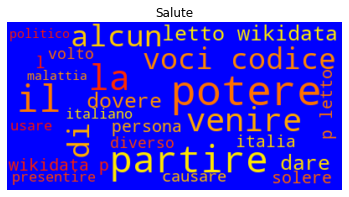

In [44]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(salute)

plt.figure()
plt.title("Salute")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

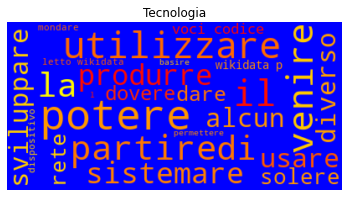

In [45]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(tecnologia)

plt.figure()
plt.title("Tecnologia")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

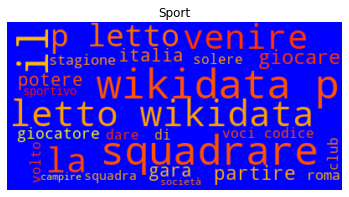

In [46]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(sport)

plt.figure()
plt.title("Sport")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Costruire WordCloud senza common words

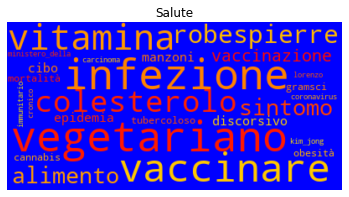

In [47]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(salute_wc)

plt.figure()
plt.title("Salute")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Scikit learn (sklearn)... una libreria indispensabile per il machine learning con Python

All'interno di sklearn si trovano molti "strumenti" già pronti all'uso per effettuare molte operazioni comuni nel trattamento dei dati in ambito machine learning come ad esempio:

- la standardizzazione delle variabili ---> sklearn.preprocessing.StandardScaler
- suddivisione del dataset in train e test set ---> sklearn.model_selection.train_test_split

Oltre a tanti algoritmi di ML naturalmente...:

- Regressione logistica ---> sklearn.linear_model.LogisticRegression
- Eccetera eccetera


In [48]:
from sklearn.feature_extraction.text import CountVectorizer

##### Spiegazione

CountVectorizer costruisce un dizionario con la frequenza delle parole e permette, inoltre, alcune operazioni con i dati.

In particolare andremo a costruire, frase per frase, un array di zeri (0) di lunghezza pari al numero di parole presenti nel vocabolario.

Siccome le parole rappresentano l'indice dell'array, per ogni parola presente nella frase l'array avrà valore uno (1).

##### Esempio pratico

In [49]:
cv_esempio = CountVectorizer()

In [50]:
testo_prova = "primo testo di prova"

testo_test = "secondo testo di prova"

In questo caso la lunghezza dell'array sarà di 4

In [51]:
cv_esempio.fit(testo_prova.split())

cv_esempio.get_feature_names()

['di', 'primo', 'prova', 'testo']

In [52]:
cv_esempio.get_feature_names().index('testo')

3

In [53]:
print(testo_prova)

cv_esempio.transform(testo_prova.split()).toarray()

primo testo di prova


array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [54]:
np.max(cv_esempio.transform(testo_prova.split()).toarray(), axis=0)

array([1, 1, 1, 1])

In [55]:
df = pd.DataFrame(data = np.max(cv_esempio.transform(testo_prova.split(" ")).toarray(), axis=0).reshape((1,4)), \
                  columns=cv_esempio.get_feature_names())
df

,di,primo,prova,testo
0,1,1,1,1


Cosa accade quando c'è una parola che non conosce?

In [56]:
print(testo_test)

cv_esempio.transform(testo_test.split()).toarray()

secondo testo di prova


array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

Semplicemente la scarta!

In [57]:
np.max(cv_esempio.transform(testo_test.split()).toarray(), axis=0)

array([1, 0, 1, 1])

In [58]:
df = pd.DataFrame(data = np.max(cv_esempio.transform(testo_test.split()).toarray(), axis=0).reshape((1,4)), \
                  columns=cv_esempio.get_feature_names())
df

,di,primo,prova,testo
0,1,0,1,1


In [59]:
vocab = Vocabulary('vocab.json', tokens = True)
vocab.import_stopwords("stopwords_ita.txt")

Sono stati caricati n.81039 elementi
Dopo la riduzione ci sono n.18101 elementi


##### Applicazione

Con questa operazione importiamo direttamente il dizionario nel CountVectorizer senza che quest'ultimo processi prima i vari articoli.

In [60]:
cv = CountVectorizer(vocabulary = vocab.word2idx)

Altro strumento molto importante che troviamo nella libreria sklearn è LabelEncoder.

Come dice il nome ci permette di codificare le etichette, ovvero trasformarle in numeri. La trasformazione di stringhe in numeri è sempre un passaggio obbligato dato che gli algoritmi di ML lavorano con i numeri non con le parole.

E' solitamente utilizzata per la codifica delle variabili risposta in problemi di classificazione (classi).

Si compone di un metodo "fit" che addestra l'oggetto e di un metodo "tranform" che le codifica in numeri.

In [61]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

labelencoder.fit(['salute','tecnologia','sport'])

classes = labelencoder.transform(['salute','tecnologia','sport'])

classes

array([0, 2, 1])

Codifica in indice

In [62]:
labelencoder.transform(['salute'])

array([0])

Decodifica in classe

In [63]:
labelencoder.classes_[0]

'salute'

##### Mettiamo tutto insieme...

In [64]:
def preparazione_dati(articolo):

        estrati_dati(articolo)

        dati = estrati_dati(articolo)
                
        y = dati[1]
        
        y = labelencoder.transform([y])[0]

        doc = nlp(dati[0])
        
        """
        Esclude le parole che sono stopwords e 
        trasforma in OOV le parole non comprese nel vocabolario
        
        OOV = Out Of Vocabulary
        
        """

        tokens = [token.lemma_.lower() if token.lemma_ in vocab.word2idx.keys() else 'OOV' for token in doc if not (token.lemma_ in vocab.stopwords)]

        testo = ""

        for token in tokens:
           
            testo += " " + token
            
        X = cv.transform(testo.split()).toarray()
        X = np.max(X, axis=0).tolist()
        
        return X, y

#### Carichiamo l'algoritmo di ML

In [65]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(fit_intercept=False)

Ho scelto quest'algoritmo semplicemente perchè ha un metodo che mi permette di estrarre più facilmente l'importanza associata ad ogni parola. Anche se non è l'unico che permette di fare questo.

Come per il LabelEncoder gli algoritmi di ML devono essere prima addestrati passando loro un dataset *(train set)* che comprende il valore della variabile risposta (in questo caso la classe) e poi testati su un dataset *(test set)* che contiene solo le varibili esplicative.

In [66]:
articoli = iter(glob.glob("archivio/*.txt"))

In [67]:
arr_X, arr_y = [], []

i = 0

# Rappresenta la dimension (numero di articoli)
# che l'algoritmo prcocessa ad ogni step
batch_size = 64

while True:
    
    
    try:
        
        i += 1
        
        # Faremo stoppare l'addestramento del modello (fitting)
        # dopo i primi 1024 articoli così da usare i rimanenti
        # come test set.
        if i > 1024:
            raise StopIteration

        articolo = next(articoli)
        
        # La variabile risp contiene
        # indice 0 l'array di dati
        # indice 1 l'array della classe di appartenenza
        risp = preparazione_dati(articolo)

        # Qui andiamo a costruire la matrice (X) e l'array (y)
        # che saranno processati dal classificatore
        arr_X.append(risp[0])
        arr_y.append(risp[1]) 

        # Il classificatore effettua i suoi calcoli solo quando
        # la dimensione dell'array X è pari al batch size
        if i % batch_size == 0:

            classifier.partial_fit(arr_X, arr_y, classes)

            # Ad ogni step di addestramento azzeriamo
            # i valori per caricarli nuovamente per il
            # nuovo batch
            arr_X, arr_y = [], []
                    
    except StopIteration:
        print("Fine")
        break


Fine


#### Come si valuta la bontà del modello?

Se si trattasse di statistica inferenziale avremmo la possibilità di applicare dei test statistici che, attraverso l'esame del valore soglia, ci dicono se possiamo accettare o meno il modello... ma in questo caso ?

citazione: _**"TUTTI I MODELLI SONO SBAGLIATI... ALCUNI SONO UTILI"**_.

Nei problemi di classificazione (come questo) **uno dei modi** per valutare la bontà del modello è misurare quante volte classifica correttamente gli articoli del test_set diviso il totale degli articoli che compongono il test_set. Questa misura si chiama "accuracy". Si confronta, poi, il valore ottenuto con l'accuracy del trainset.

**Se i due valori sono elevati e, soprattutto, sono abbastanza vicino tra loro possiamo dire che l'algoritmo è stato in grado di generalizzare** ovvero di interpolare la regola che determina il fenomeno osservato.

Ricordo che il test set potrebbe/dovrebbe contenere parole sulle quali l'algorimo non è stato addestrato.

#### Applichiamo il classificatore al test set

In [68]:
articolo = next(articoli)
risp = preparazione_dati(articolo)

In [69]:
# Classe di appartenenza dell'articolo
risp[1]

0

In [70]:
# Classe prevista dal classificatore
classifier.predict([risp[0]])[0]

0

### Costruzione dell'accuracy per i test set

In [71]:
n = 0

# Totale articoli processati
total = 0

# Numero articoli correttamente classificati
correct = 0


while True:
    
    n += 1

    try:
        
        total += 1
        
        articolo = next(articoli)
        
        risp = preparazione_dati(articolo)
        
        """
        Costruzione manuale dell'accuracy
        """
        
        # Se l'algoritmo classifica correttamente allora
        # incrementare la varibile correct
        if risp[1] == classifier.predict([risp[0]])[0]:
            
            correct += 1
            
        if n % 100 == 0:
            print(f"partial {int(correct/total * 100)}%")
            
                
    except StopIteration:
        # Qui stampa l'accuracy finale
        print(f"Fine: {correct/total*100:0.2f}%")
        break

partial 80%
partial 83%
partial 84%
partial 85%
Fine: 85.71%


##### Qualche dettaglio sul classificatore

L'indice che identifica la classe "salute" è:

In [72]:
labelencoder.transform(['salute'])[0]

0

I pesi che l'algoritmo assegna a questa classe si estraggono attraverso il metodo coef_ _(Ecco perchè avevo scelto quest'algoritmo)_.

Come si può notare, la lunghezza di questi pesi corrisponde alla lunghezza delle parole del vocabolario (o meglio dei tokens).

In [73]:
print(len(classifier.coef_[0]))
print(len(vocab.idx2word))

18101
18101


Estraiamo adesso il valore massimo assunto dai pesi e poi l'indice associato.

In [74]:
# Valore max
np.max(classifier.coef_[0])

74.14730598121594

In [75]:
# Indice della parola con valore max
indice = str(np.argmax(classifier.coef_[0]))
print(indice)

1559


L'indice ci serve per individuare qual'è la parola, per la classe "salute", alla quale viene attribuita l'importanza maggiore.

In [76]:
# Parola con valore max
vocab.idx2word[indice]

'malattia'

#### Un DataFrame per meglio visualizzare...

In [77]:
tot = {k:v for k,v in zip(vocab.word2idx.keys(), classifier.coef_[0])}

In [78]:
tot_salute = {k:v for k,v in sorted(tot.items(), key=lambda item: item[1], reverse=True)}

In [79]:
df = pd.DataFrame()
df = df.from_dict(tot_salute, orient='index')

print(f"Prime 10 parole:\n {df.head(10)}\n\n")

print(f"Ultime 10 parole:\n {df.tail(10)}")

Prime 10 parole:
                      0
malattia     74.147306
marzo        69.204152
sanitario    59.317845
ospedale     59.317845
attribuire   59.317845
ottenere     54.374691
strutturare  54.374691
ricordare    54.374691
quotidiano   49.431537
riferimento  49.431537


Ultime 10 parole:
                      0
campo       -44.488384
gara        -49.431537
ormai       -49.431537
ingegneria  -54.374691
sportivo    -59.317845
salute      -59.317845
tecnologia  -69.204152
società     -69.204152
tecnologico -74.147306
tecnico     -79.090460
